# EDS 296 Homework 1

Author: Haylee Oyler

Locate monthly data for a historical simulation run with any two CMIP6 models of your
choice. 

You may choose any climate variable you like; however, note that three-dimensional data is
generally larger and can be slower to load, so I recommend either choosing a two-
dimensional data field or reading in only the surface level if you choose 3D information.
Some common choices of variables to analyze, and their CMIP names, include:

- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)

Download (or write Python code to access via the cloud) data from the historical simulation,
as well as corresponding future projection information for two different future emissions
scenarios, for each model. NOTE: particularly if you’re working with the ESGF, there are
many different scenarios listed - let’s stick to the main SSPs (they will be called ‘ssp126’,
‘ssp245’, ‘ssp370’, or ‘ssp585’

Choose a region that you’re interested in to analyze, anywhere in the world. The only
constraint is that your region needs to be large enough to include at least one model grid
point

a. Describe, in markdown text, the climate of that region in general terms. What is it like? Is
it a forest, a desert, polar, tropical, urban, etc? What types of climate change impacts might
you expect there?

b. Read in the surface air temperature datasets from 1 and 2, and create annually averaged,
area-weighted, regionally averaged time series for your region of interest. (Examples of how
to do this can be found in the various Time Series Plots tutorials we used in class.)

Since you’re working with two models and two scenarios, this should result in four time
series — however, if you used the same historical ensemble member for multiple scenarios,
they will end up lying on top of each other and that’s ok

Plot your regional time series, and fit a trend line for two different time periods:
- historical (1850-2015)
- historical plus future (1850-2100)
Over both of those time periods, is the temperature of your region changing, and is that
change statistically significant

Write 1-2 paragraphs in markdown text describing the results of your plot, and what you
think they might mean for humans or ecosystems located in your study region

In [36]:
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import numpy as np 

In [11]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a df for easier access
cat_df = catalog.df

My area of interest is the Congo Basin in West Africa. Through some basic googling, I've found two models that appear well suited to documenting climate changes in that region: GFDL-ESM4 and INM-CM5-0. These are the Institute for Numerical Mathematics (INM) climate model version 5 generation 0 and the Geophysical Fluid Dynamics Laboratory earth systems model 4.

In [12]:
# View which models are avaiable
cat_df.source_id.unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-LR',
       'ECMWF-IFS-HR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'CanESM5',
       'SAM0-UNICON', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-H', 'MRI-AGCM3-2-S',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

### Catalog search

In [ ]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: Selecting CMIP for historical and ScenarioMIP for future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Models selected earlier
source_id = ['GFDL-ESM4' ,'INM-CM5-0']

# experiment_id: I chose the historical data and the ssp370 projection as my two time experimental configurations
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: Changed the ensemble member here because there was more data available
member_id = 'r1i1p1f1'

# table_id: Selecting monthly atmospheric data, which is the table that precipitation is stored in. 
table_id = 'Amon' 

# variable_id: I chose precipitation flux in kg m-2 s-1, it includes both liquid and solid phases.
variable_id = 'pr' 

In [25]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, 
                     experiment_id=experiment_ids, table_id=table_id, variable_id=variable_id,
                     member_id=member_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
4,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/CMIP/INM/INM-CM5-0/histor...,NaN,20190610
5,ScenarioMIP,INM,INM-CM5-0,ssp370,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190618
6,ScenarioMIP,INM,INM-CM5-0,ssp126,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190619
7,ScenarioMIP,INM,INM-CM5-0,ssp245,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190619
8,ScenarioMIP,INM,INM-CM5-0,ssp585,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190724
9,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


### Model selection and cleaning

Let's separate our data by their respective model sources and selected the historical data and two future projections for each.

In [26]:
# Read in the historical data file for INM
hist_inm = xr.open_zarr(res.df['zstore'][4], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_inm = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True})

# Read in the SSP245 data file
ssp245_inm = xr.open_zarr(res.df['zstore'][7], storage_options={'anon': True})

In [27]:
# Read in the historical data file for GFDL
hist_gfdl = xr.open_zarr(res.df['zstore'][9], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_gfdl = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})

# Read in the SSP245 data file
ssp245_gfdl = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

In [28]:
# Concatenate historical and future projection data
inm_data = xr.concat([hist_inm, ssp370_inm, ssp245_inm], dim="time")

gfdl_data = xr.concat([hist_gfdl, ssp370_gfdl, ssp245_gfdl], dim="time")


In [29]:
inm_data

<xarray.Dataset>
Dimensions:    (lat: 120, bnds: 2, lon: 180, time: 4044)
Coordinates:
  * lat        (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
    lat_bnds   (lat, bnds) float64 -90.0 -88.5 -88.5 -87.0 ... 88.5 88.5 90.0
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    lon_bnds   (lon, bnds) float64 -1.0 1.0 1.0 3.0 ... 355.0 357.0 357.0 359.0
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(718, 120, 180), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  90885.0
    cmor_version:           3.4.0
    ...                     ...
    title:                  INM-CM5-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/97f6019a-5478-4971-b016-aaf326b63d98...
    variable_id:            pr
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/97f6019a-5478-4971-b016-aaf326b63d98...
    version_id:             v20190610

In [30]:
gfdl_data

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 4044)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 0.0 1.25 1.25 2.5 ... 357.5 358.8 358.8 360.0
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            pr
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-09-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/29468e1c-b66b-40d6-92aa-9851fba964ee...
    version_id:             v20190726

In [31]:
# Convert time to datetime64 format
time_inm = inm_data.time.astype('datetime64[ns]')

time_gfdl = gfdl_data.time.astype('datetime64[ns]')

### Plotting

My area of interest is going to be the Congo Basin in West Africa. The Congo Basin is home to one of the largest rainforests in the world and understanding how carbon storage and other biogeochemical fluxes will change under the influence of climate change is crucial. 

12°E - 34°E and 9.3°N - 13.4°S

In [41]:
# Select tas variable, store as xarray DataArray
pr = inm_data['pr']

# Define min/max bounds for region of interest (NYC)
lat_min, lat_max = 9.3, 13.4
lon_min, lon_max = 12, 34


In [42]:
# Subsetting for INM model
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
congo_lat_inm = (pr.lat >= lat_min) & (pr.lat <= lat_max)
congo_lon_inm = (pr.lon >= lon_min) & (pr.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_congo_inm = pr.where(congo_lat_inm & congo_lon_inm, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_inm = pr_congo_inm.mean(dim=["lat", "lon"])

In [43]:
# Select a time period of interest
# tas_NYC = tas_NYC.sel(time=slice('1910-01-01','2010-12-31'))

In [44]:
# Calculate the annual mean precipitation
annual_mean_inm = pr_congo_inm.groupby('time.year').mean()

In [45]:
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x_inm = np.polyfit(annual_mean_inm.year, annual_mean_inm, 1)

# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x_inm)  

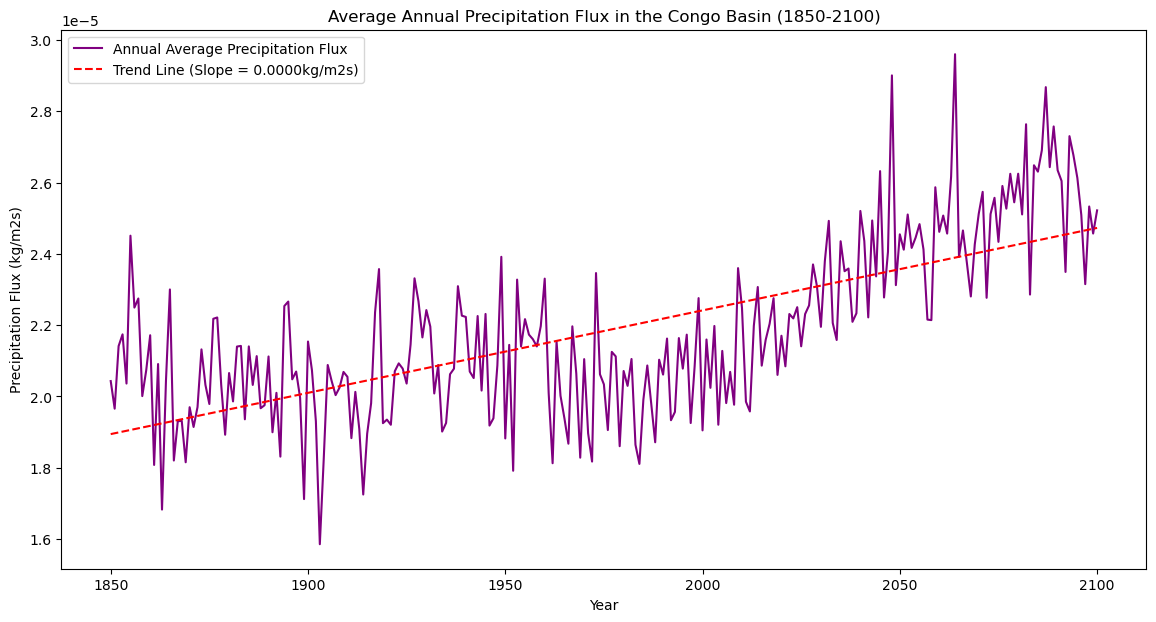

In [ ]:
# Plot our annual data and the trend line
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(annual_mean_inm.year, annual_mean_inm, label= 'Annual Average Precipitation Flux', color='purple')
ax.plot(annual_mean_inm.year, trend_line(annual_mean_inm.year), color='red', linestyle='--', label=f'Trend Line (Slope = {x_inm[0]:.4f}kg/m2s)')
ax.set_title('Average Annual Precipitation Flux in the Congo Basin (1850-2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation Flux (kg/m2s)')
ax.legend()
plt.show()

In [49]:
# Subsetting for gfdl model

# Select tas variable, store as xarray DataArray
pr = gfdl_data['pr']

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
congo_lat_gfdl = (pr.lat >= lat_min) & (pr.lat <= lat_max)
congo_lon_gfdl = (pr.lon >= lon_min) & (pr.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_congo_gfdl = pr.where(congo_lat_gfdl & congo_lon_gfdl, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_gfdl = pr_congo_gfdl.mean(dim=["lat", "lon"])

In [50]:
# Calculate the annual mean precipitation
annual_mean_gfdl = pr_congo_gfdl.groupby('time.year').mean()

In [51]:
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x_gfdl = np.polyfit(annual_mean_gfdl.year, annual_mean_gfdl, 1)

# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x_gfdl)  

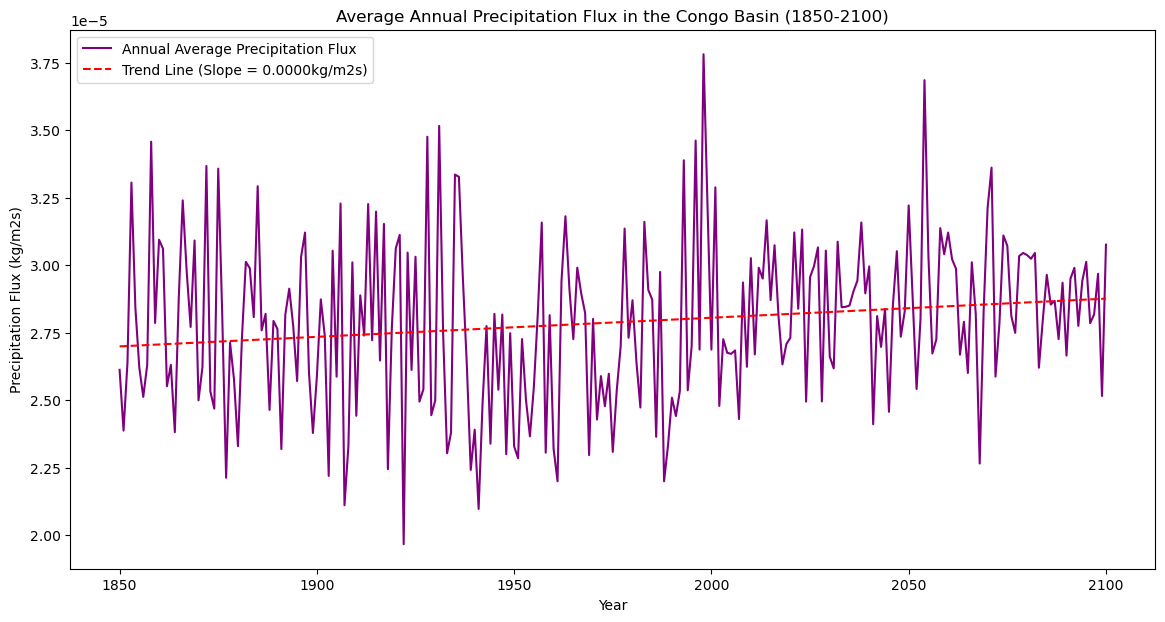

In [52]:
# Plot our annual data and the trend line
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(annual_mean_gfdl.year, annual_mean_gfdl, label= 'Annual Average Precipitation Flux', color='purple')
ax.plot(annual_mean_gfdl.year, trend_line(annual_mean_gfdl.year), color='red', linestyle='--', label=f'Trend Line (Slope = {x_gfdl[0]:.4f}kg/m2s)')
ax.set_title('Average Annual Precipitation Flux in the Congo Basin (1850-2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation Flux (kg/m2s)')
ax.legend()
plt.show()